In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_model import *

In [2]:
seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()


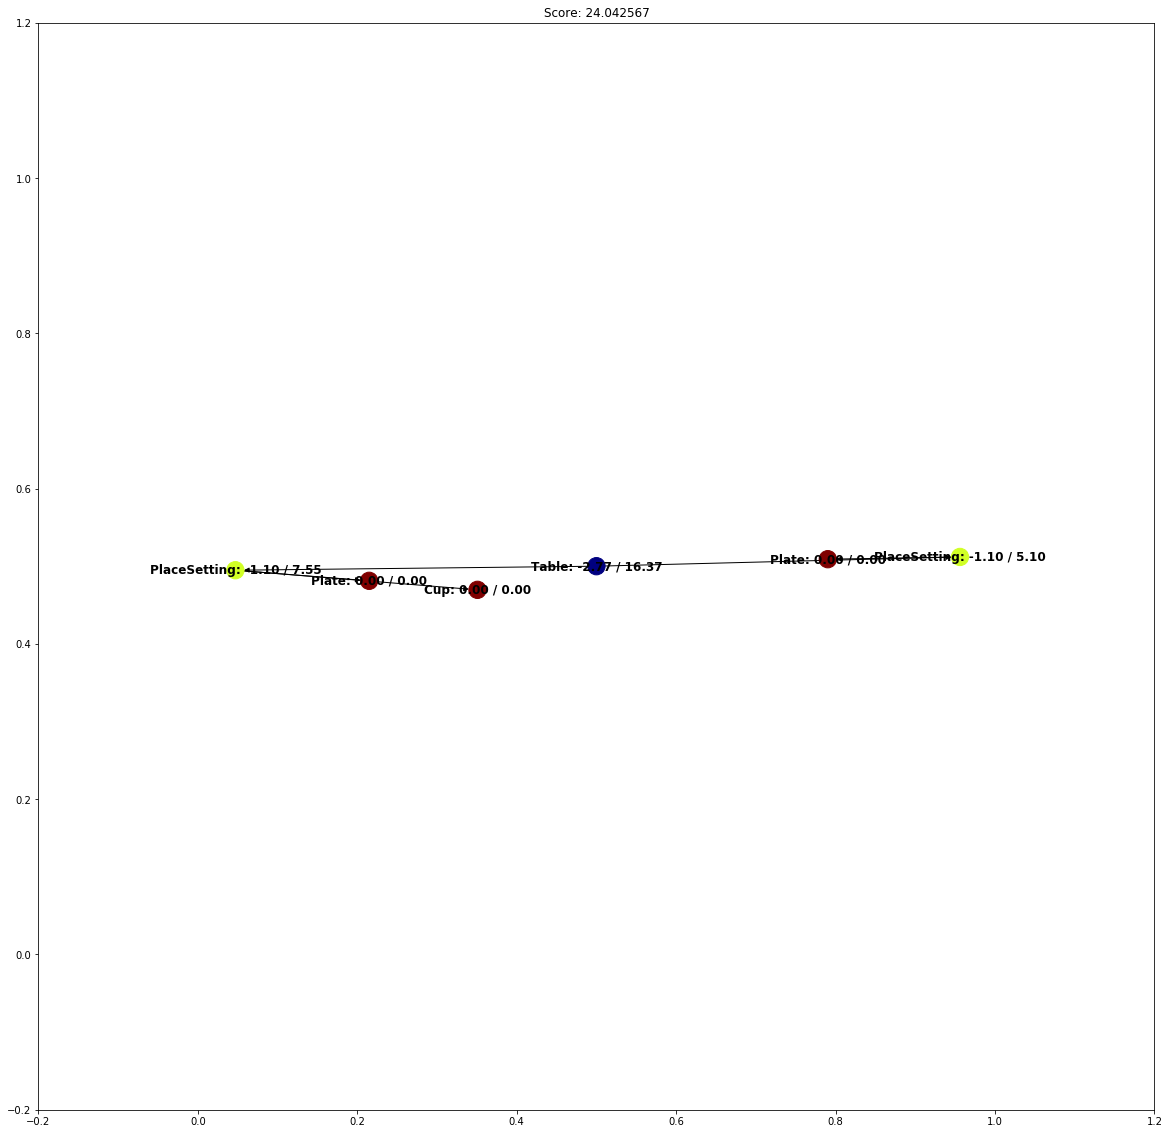

In [3]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [4]:
# Clear gradients
for param_name in pyro.get_param_store():
    pyro.param(param_name).grad = None
# Calc gradients of score w.r.t. all params
trace = poutine.trace(rerun_conditioned_parse_tree).get_trace(
    parse_tree, score_terminal_products=True, score_nonterminal_products=True)
score = trace.log_prob_sum()
print("score: ", score)
score.backward(retain_graph=True)
def print_param_store(grads=False):
    for param_name in pyro.get_param_store().keys():
        val = pyro.param(param_name)#.tolist()
        grad = pyro.param(param_name).grad
        #if isinstance(val, float):
        #    val = [val]
        if grads:
            print(param_name, ": ", val.data, ", unconstrained grad: ", pyro.get_param_store()._params[param_name].grad)
        else:
            print(param_name, ": ", val.data)
print_param_store(grads=True)
fork_node = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
#print(list(parse_tree.predecessors(fork_node))[0].offset_dist.scale)

score:  tensor(24.0426, grad_fn=<AddBackward0>)
place_setting_production_weights :  tensor([3.3333e-10, 3.3333e-01, 3.3333e-10, 3.3333e-01, 3.3333e-10, 3.3333e-01,
        3.3333e-10, 3.3333e-10, 3.3333e-10]) , unconstrained grad:  tensor([-6.6667e-10,  3.3333e-01, -6.6667e-10, -6.6667e-01, -6.6667e-10,
         3.3333e-01, -6.6667e-10, -6.6667e-10, -6.6667e-10])
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000]) , unconstrained grad:  None
place_setting_cup_mean :  tensor([0.0000, 0.3100, 0.0000]) , unconstrained grad:  tensor([  8.1085, -59.0081,  -0.1944])
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000]) , unconstrained grad:  tensor([-0.6559, -0.9172, -1.4859])
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000]) , unconstrained grad:  tensor([138.2776, 138.2867,  -0.3183])
table_independent_set_production_probs :  tensor([0.5000, 0.5000, 0.5000, 0.5000]) , unconstrained grad:  tensor([ 0.5000, -0.5000,  0.5000, -0.5000])
place_setting_left_fork_

StopIteration: 

In [ ]:
fork = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
fork_prod = list(parse_tree.predecessors(fork))[0]
loc = pyro.param("place_setting_left_fork_mean") # fork_prod.offset_dist.mean
scale = pyro.param("place_setting_left_fork_var") # fork_prod.offset_dist.variance
loc.grad = None
scale.grad = None

local_score = fork_prod.score_products(list(parse_tree.predecessors(fork_prod))[0], [fork])
local_score.backward(retain_graph=True)
print(local_score)
print("Loc: ", loc, loc.grad)
print("Scale: ", scale, scale.grad)

In [ ]:
score = poutine.trace()

In [ ]:
import yaml
import multiprocessing
from functools import partial

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]

all_observed_trees = []
for env in envs:
    tree, score = guess_parse_tree_from_yaml(
        env, outer_iterations=10,
        num_attempts=3, verbose=False)
    print("Tree with score %f" % score)
    all_observed_trees.append(tree)

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_tree in all_observed_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    print(gt_mean, gt_std)
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    
    
print(scores_by_class)
plt.tight_layout()

In [ ]:
draw_parse_tree(all_observed_trees[2], label_name=True, label_score=True)

In [13]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]


# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
def model(observed_tree):
    rerun_conditioned_parse_tree(observed_tree, score_terminal_products=True, score_nonterminal_products=True)

def guide(observed_tree):
    rerun_conditioned_parse_tree(observed_tree, score_terminal_products=False, score_nonterminal_products=True)
    

# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    for p_k in range(5):
        env = random.choice(envs)
        observed_tree, score = guess_parse_tree_from_yaml(env, outer_iterations=5, num_attempts=5)
        print("Obs tree with score %f" % score)
        losses.append(-1. * score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in observed_tree.nodes])
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
    print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

place_setting_production_weights :  tensor([3.3191e-10, 2.5117e-01, 3.0871e-10, 4.3292e-01, 3.1024e-10, 3.1591e-01,
        3.0871e-10, 3.1102e-10, 3.0871e-10])
place_setting_left_fork_mean :  tensor([-0.1497,  0.1418,  0.0228])
place_setting_cup_mean :  tensor([-0.0025,  0.3091,  0.0754])
place_setting_plate_var :  tensor([0.0112, 0.0163, 2.3086])
place_setting_plate_mean :  tensor([-0.0035,  0.1485,  0.1471])
table_independent_set_production_probs :  tensor([0.4559, 0.4780, 0.4537, 0.4810])
place_setting_left_fork_var :  tensor([0.0120, 0.0116, 0.0156])
place_setting_cup_var :  tensor([0.0390, 0.0144, 4.1444])
Obs tree with score -2.519107
Obs tree with score -2.860190
Obs tree with score 42.284791
Obs tree with score 35.221964
Obs tree with score 6.736203
Loss:  -15.7727323203
Place setting plate mean:  tensor([-0.0135,  0.1385,  0.1571], requires_grad=True)
Place setting plate var:  tensor([0.0111, 0.0165, 2.3318], grad_fn=<AddBackward0>)
Obs tree with score -0.547071
Obs tree with

Obs tree with score -548.903754
Loss:  167.828545615
Place setting plate mean:  tensor([-0.0028,  0.1386,  0.2426], requires_grad=True)
Place setting plate var:  tensor([0.0108, 0.0195, 2.7258], grad_fn=<AddBackward0>)
Obs tree with score -615.786711
Obs tree with score -654.040197
Obs tree with score 22.222734
Obs tree with score 9.307873
Obs tree with score 13.071712
Loss:  245.044917777
Place setting plate mean:  tensor([-0.0055,  0.1388,  0.2464], requires_grad=True)
Place setting plate var:  tensor([0.0108, 0.0196, 2.7433], grad_fn=<AddBackward0>)
Obs tree with score -78.394918
Obs tree with score -482.672085
Obs tree with score 13.487596
Obs tree with score 2.769725
Obs tree with score -809.276529
Loss:  270.817242097
Place setting plate mean:  tensor([-0.0080,  0.1398,  0.2492], requires_grad=True)
Place setting plate var:  tensor([0.0109, 0.0197, 2.7615], grad_fn=<AddBackward0>)
Obs tree with score -113.671208
Obs tree with score 24.979254
Obs tree with score -569.940888
Obs tr

Obs tree with score 29.454232
Obs tree with score 43.335252
Obs tree with score 32.251332
Obs tree with score 20.930850
Obs tree with score 19.727370
Loss:  -29.1398071474
Place setting plate mean:  tensor([-0.0091,  0.1476,  0.3310], requires_grad=True)
Place setting plate var:  tensor([0.0107, 0.0209, 3.0874], grad_fn=<AddBackward0>)
Obs tree with score 31.204763
Obs tree with score 17.016919
Obs tree with score 17.696509
Obs tree with score 15.979024
Obs tree with score 18.424221
Loss:  -20.0642871411
Place setting plate mean:  tensor([-0.0069,  0.1467,  0.3352], requires_grad=True)
Place setting plate var:  tensor([0.0107, 0.0209, 3.0981], grad_fn=<AddBackward0>)
Obs tree with score 34.719858
Obs tree with score 24.640073
Obs tree with score -27.074764
Obs tree with score 7.359196
Obs tree with score 23.143261
Loss:  -12.5575246145
Place setting plate mean:  tensor([-0.0073,  0.1467,  0.3401], requires_grad=True)
Place setting plate var:  tensor([0.0107, 0.0209, 3.1106], grad_fn=<A

Obs tree with score 16.460825
Obs tree with score 19.081371
Loss:  -13.1065334556
Place setting plate mean:  tensor([-0.0141,  0.1574,  0.3894], requires_grad=True)
Place setting plate var:  tensor([0.0099, 0.0212, 3.1856], grad_fn=<AddBackward0>)
Obs tree with score -4.732911
Obs tree with score 16.253523
Obs tree with score -21.384752
Obs tree with score -62.099431
Obs tree with score -114.240787
Loss:  37.2408716079
Place setting plate mean:  tensor([-0.0143,  0.1588,  0.3916], requires_grad=True)
Place setting plate var:  tensor([0.0099, 0.0212, 3.1912], grad_fn=<AddBackward0>)
Obs tree with score 15.199797
Obs tree with score 26.578902
Obs tree with score 17.886964
Obs tree with score 12.824675
Obs tree with score -0.690861
Loss:  -14.3598955171
Place setting plate mean:  tensor([-0.0139,  0.1597,  0.3941], requires_grad=True)
Place setting plate var:  tensor([0.0099, 0.0212, 3.1971], grad_fn=<AddBackward0>)
Obs tree with score 17.247291
Obs tree with score -14.456351
Obs tree wit

Obs tree with score -87.453675
Obs tree with score 17.757527
Obs tree with score 25.821062
Obs tree with score 1.460327
Obs tree with score 19.335910
Loss:  4.61576967912
Place setting plate mean:  tensor([-0.0144,  0.1538,  0.4013], requires_grad=True)
Place setting plate var:  tensor([0.0096, 0.0222, 3.2502], grad_fn=<AddBackward0>)
Obs tree with score 19.242066
Obs tree with score 17.656673
Obs tree with score 14.810905
Obs tree with score 18.587745
Obs tree with score 18.017576
Loss:  -17.6629927772
Place setting plate mean:  tensor([-0.0126,  0.1542,  0.4026], requires_grad=True)
Place setting plate var:  tensor([0.0097, 0.0222, 3.2521], grad_fn=<AddBackward0>)
Obs tree with score 18.652556
Obs tree with score -2.133421
Obs tree with score -262.727246
Obs tree with score 13.658544
Obs tree with score -10.122828
Loss:  48.534478848
Place setting plate mean:  tensor([-0.0109,  0.1583,  0.4039], requires_grad=True)
Place setting plate var:  tensor([0.0097, 0.0224, 3.2527], grad_fn=<A

In [ ]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [5]:
# Generate a bunch of envs + their parse trees
generated_envs_and_trees = []
for k in range(100):
    parse_tree = generate_unconditioned_parse_tree()
    generated_envs_and_trees.append((
        convert_tree_to_yaml_env(parse_tree),
        parse_tree))

In [6]:
# Instead train on environments in which I have perfect parse trees
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.5, 0.5)}
optimizer = Adam(adam_params)
    
pyro.param("place_setting_left_fork_mean").data[0] = 0.0
# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    random.shuffle(generated_envs_and_trees)
    for env, best_observed_tree in generated_envs_and_trees[:5]:
        best_score, _ = score_tree(best_observed_tree)
        losses.append(-1. * best_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in best_observed_tree.nodes])
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    #print("Val: ", pyro.param("place_setting_left_fork_mean").detach().cpu().numpy())
    #print("Grad: ", pyro.get_param_store()._params["place_setting_left_fork_mean"].grad)
    #for param in params:
    #   param.data + param.grad*100
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
    #print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    #print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

place_setting_production_weights :  tensor([3.3333e-10, 3.3333e-01, 3.3333e-10, 3.3333e-01, 3.3333e-10, 3.3333e-01,
        3.3333e-10, 3.3333e-10, 3.3333e-10])
place_setting_left_fork_mean :  tensor([0.0000, 0.1600, 0.0000])
place_setting_cup_mean :  tensor([0.0000, 0.3100, 0.0000])
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000])
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000])
table_independent_set_production_probs :  tensor([0.5000, 0.5000, 0.5000, 0.5000])
place_setting_left_fork_var :  tensor([0.0100, 0.0100, 0.0100])
place_setting_cup_var :  tensor([0.0500, 0.0100, 3.0000])
Loss:  82.40672111
Loss:  19.5105358728
Loss:  74.4250828142
Loss:  8.02731167452
Loss:  5.2193783953
Loss:  -8.93486782789
Loss:  1.03481568867
Loss:  -4.65653687651
Loss:  -0.223080061998
Loss:  -0.10466266075
Loss:  -8.542678806
Loss:  -16.9380332829
Loss:  -20.2404912442
Loss:  -20.8112150104
Loss:  -21.8299023173
Loss:  -22.5073552795
Loss:  -19.0174911114
Loss:  -20.0513282128
Los

In [ ]:
pyro.get_param_store()._params["place_setting_left_fork_var"]

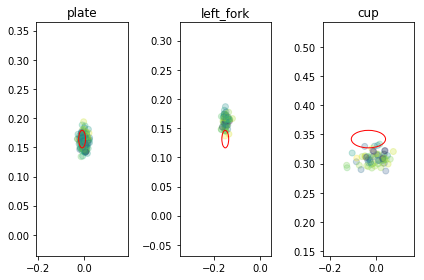

In [14]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_env, observed_tree in generated_envs_and_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    

plt.tight_layout()